In [1]:
import random

from other.audio_utils import *
import os
from tqdm import tqdm
import numpy as np
import webrtcvad

In [2]:
target_sample_rate = 8000
vad_window_ms = [10, 20, 30][2]
vad_overlap_ratio = 0.5

In [3]:
class WebrtcVadLabelMaker:
    def __init__(self, mode=2, vad_window_ms=30, vad_overlap_ratio=0):
        self.vad_window_ms = vad_window_ms
        self.vad_overlap_ratio = vad_overlap_ratio
        self.vad = webrtcvad.Vad(mode)

    def __call__(self, au: AudioWorker, label_region_s=0.1, label_overlap_ratio=0.5):
        # need to be commented, bc its overcomplicated
        simple_wave = au.wave.squeeze(0)
        vad_window = int(self.vad_window_ms * au.rate / 1000)
        vad_hop = int(vad_window * self.vad_overlap_ratio)
        frames = torch.nn.functional.unfold(simple_wave.unsqueeze(0).unsqueeze(0).unsqueeze(-1),
                                            kernel_size=(vad_window, 1),
                                            stride=(vad_hop, 1)).squeeze(0).T
        speech_mask = []
        for frame in frames:
            bytes_like = frame.mul(32767).to(torch.int16).numpy().tobytes()
            is_speech = self.vad.is_speech(bytes_like, au.rate)
            speech_mask.append(is_speech)

        item_wise_mask = np.full_like(simple_wave, False, dtype=bool)
        for i, is_speech in enumerate(speech_mask):
            
            item_wise_mask[vad_hop * i:vad_hop * i + vad_window] = is_speech or item_wise_mask[
                                                                                vad_hop * i:vad_hop * i + vad_window]

        return item_wise_mask

In [67]:
openSLR_data_directory, ext = '../data/train-clean-100', 'flac'
# openSLR_data_directory, ext = "../data/MSDWild/raw_wav", 'wav'
where_to_save = '../buffer'

vad = WebrtcVadLabelMaker(2, vad_window_ms, vad_overlap_ratio)

audio_files_paths = get_files_by_extension(openSLR_data_directory, ext=ext, rel=True)

labels_path = f'webrtc_labels_{target_sample_rate}_{vad_window_ms}_{int(vad_overlap_ratio * 100)}'
labels_path = os.path.join(where_to_save, labels_path)
os.makedirs(labels_path, exist_ok=True)
data_samples = len(audio_files_paths)
print(data_samples, "files like:", np.random.choice(audio_files_paths))
print(labels_path)

28539 files like: 4640\19187\4640-19187-0005.flac
../buffer\webrtc_labels_8000_30_50


In [68]:
if data_samples > 0:
    for audio_path in tqdm(audio_files_paths[:], total=data_samples):
        aw = AudioWorker(os.path.join(openSLR_data_directory, audio_path)).load()
        aw.resample(target_sample_rate)
        iwm = vad(aw)
        
        filename = os.path.basename(audio_path)
        np.packbits(iwm).tofile(os.path.join(labels_path, f"{filename}.bin"))

        

else:
    print(len(audio_files_paths), "audio files not found")

 17%|█▋        | 4972/28539 [01:12<05:43, 68.66it/s]


KeyboardInterrupt: 

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [45]:
from numpy import histogram

audio_files_paths = get_files_by_extension("../data/MSDWild/raw_wav", ext='wav', rel=False)

means = []
maxes = []
stds = []
mines = []
for audio_path in tqdm(audio_files_paths[:3000]):
    aw = AudioWorker(audio_path).load()
    
    w = aw.wave
    E = w ** 2
    means.append(E.mean())
    stds.append(E.std())
    
    mines.append(E.min())
    maxes.append(E.max())
    
    
    

100%|██████████| 3000/3000 [00:11<00:00, 258.11it/s]


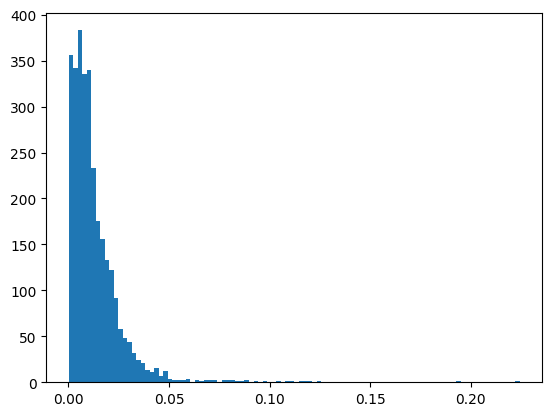

In [46]:
plt.hist(means, bins=100);

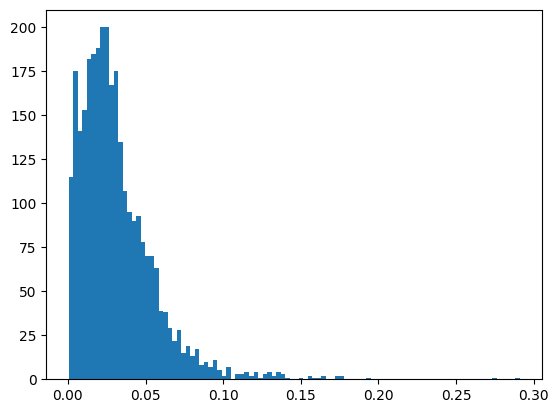

In [47]:
plt.hist(stds, bins=100);


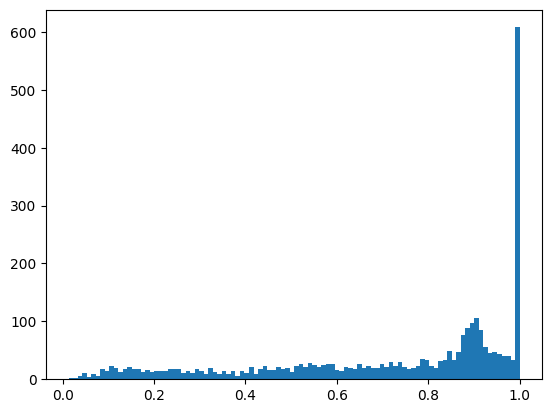

In [48]:
plt.hist(maxes, bins=100);


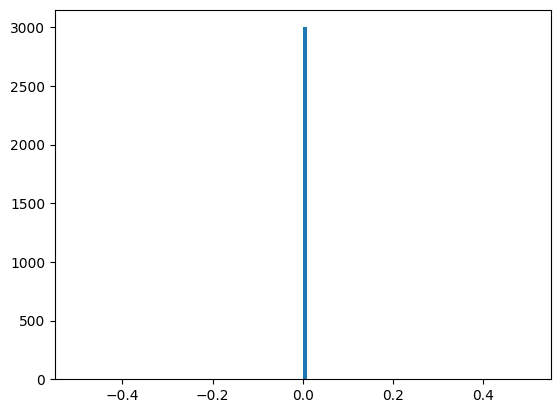

In [49]:
plt.hist(mines, bins=100);


In [ ]:
target = "3699-47246-0026.flac"
reader, chapter, *_ = target.split("-")
aw = AudioWorker(os.path.join(openSLR_data_directory, reader, chapter, target)).load()
aw.resample(target_sample_rate)
_, labels = vad(aw)


In [ ]:
print(aw.wave.shape)

items = aw.wave.size(1)
reg_width = int(aw.rate * label_region_s)
region_hop_width = int(reg_width * (1 - label_overlap_ratio))
count = int(np.floor((items - reg_width) / region_hop_width) + 1)

print((items - reg_width) / region_hop_width)

print(items, reg_width, region_hop_width, count)